<a href="https://colab.research.google.com/github/SauravMaheshkar/X-Ray-Image-Classification/blob/main/notebooks/GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages 📦 and Basic Setup

In [1]:
%%capture
!pip3 install wandb

In [12]:
import cv2
import imutils
import numpy as np
import tensorflow as tf
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils

IMAGE_SIZE = [224, 224]

# The Model 👷‍♀️

It takes a lot of time to train models, that's we use Weights and Biases Artifacts to store our model weights. You can store different versions of your datasets and models in the cloud as Artifacts. Think of an Artifact as of a folder of data to which we can add individual files, and then upload to the cloud as a part of our W&B project, which also supports automatic versioning of datasets and models. Artifacts also track the training pipelines as DAGs. Here's an example of a artifacts graph.

![](https://i.imgur.com/QQULnpP.gif)

## Download ⬇️ Weights from WandB Artifacts

In [3]:
%%capture
import wandb
run = wandb.init()
artifact = run.use_artifact('sauravmaheshkar/xray-image-classification/model:v1', type='weights')
artifact_dir = artifact.download()
run.finish()

wandb: Paste an API key from your profile and hit enter: ··········


## Load the Model 🚀

In [13]:
def get_model():
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet"
    )
    base_model.trainable = False
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(8, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

    return model
    
model = get_model()
model.load_weights('/content/artifacts/model:v1/model.h5')

# GradCAM 🔍

## Custom Class 💀

Here, we implement a Custom `GradCAM` class to generate the heatmap. 

> Code ported from PyImageSearch Tutorials

In [15]:
class GradCAM:
	def __init__(self, model, classIdx, layerName=None):
		self.model = model
		self.classIdx = classIdx
		self.layerName = layerName

		if self.layerName is None:
			self.layerName = self.find_target_layer()

	def find_target_layer(self):

		for layer in reversed(self.model.layers):
			if len(layer.output_shape) == 4:
				return layer.name

		raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

	def compute_heatmap(self, image, eps=1e-8):
		gradModel = tf.keras.models.Model(
			inputs=[self.model.inputs],
			outputs=[self.model.get_layer(self.layerName).output, 
				self.model.output])

		with tf.GradientTape() as tape:
			inputs = tf.cast(image, tf.float32)
			(convOutputs, predictions) = gradModel(inputs)
			loss = predictions[:, self.classIdx]

		grads = tape.gradient(loss, convOutputs)

		castConvOutputs = tf.cast(convOutputs > 0, "float32")
		castGrads = tf.cast(grads > 0, "float32")
		guidedGrads = castConvOutputs * castGrads * grads

		convOutputs = convOutputs[0]
		guidedGrads = guidedGrads[0]

		weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
		cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

		(w, h) = (image.shape[2], image.shape[1])
		heatmap = cv2.resize(cam.numpy(), (w, h))

		numer = heatmap - np.min(heatmap)
		denom = (heatmap.max() - heatmap.min()) + eps
		heatmap = numer / denom
		heatmap = (heatmap * 255).astype("uint8")

		return heatmap

	def overlay_heatmap(self, heatmap, image, alpha=0.5,
		colormap=cv2.COLORMAP_VIRIDIS):
		heatmap = cv2.applyColorMap(heatmap, colormap)
		output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

		return (heatmap, output)

## CAM 🙎🏻‍♂️

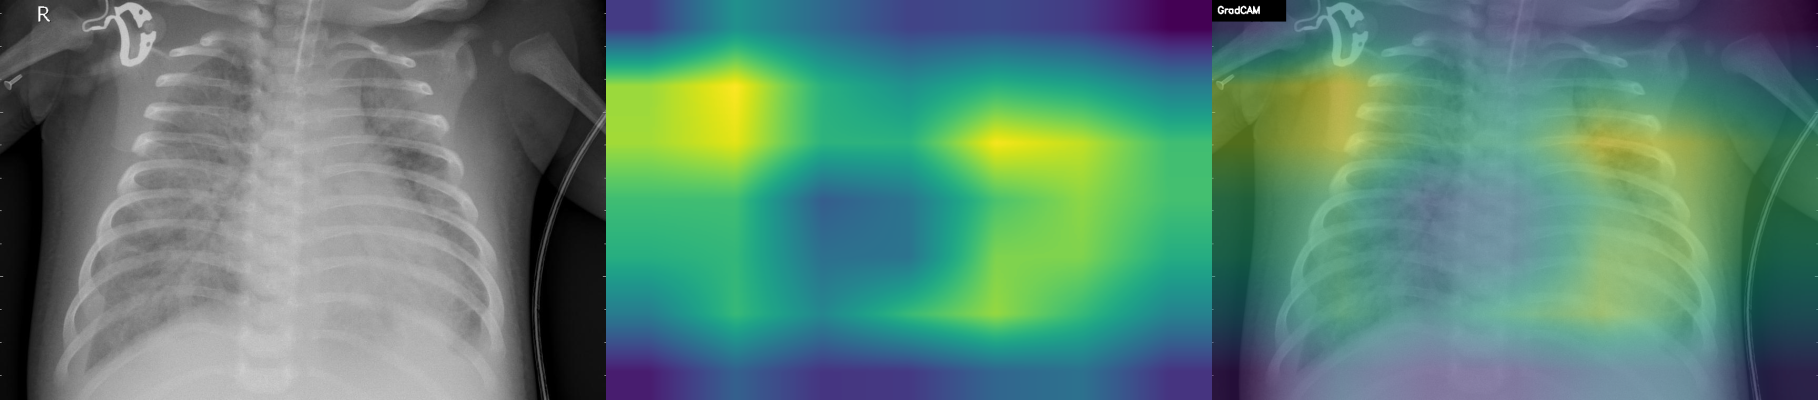

-1

In [16]:
# Change path for your own image
orig = cv2.imread("/content/pneumonia.jpeg")
w, h = 224, 224
resized = cv2.resize(orig, (w, h))🙎🏻‍♂️

image = load_img("/content/pneumonia.jpeg", target_size=(w, h))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = image.astype('float64')

preds = model.predict(image)
i = np.argmax(preds[0])

cam = GradCAM(model, i)
    
heatmap = cam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

cv2.rectangle(output, (0, 0), (140, 40), (0, 0, 0), -1)
cv2.putText(output, "GradCAM", (10, 25), cv2.FONT_HERSHEY_SIMPLEX,
	0.6, (255, 255, 255), 2)

output = np.hstack([orig, heatmap, output])
output = imutils.resize(output, height=400)
cv2_imshow(output)
cv2.waitKey(0)